<a href="https://colab.research.google.com/github/Zardian18/GPT_wine_review/blob/master/GPT__wine_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-30 12:54:00--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0.001s  

2024-01-30 12:54:00 (24.8 MB/s) - ‘helper.py’ saved [17171/17171]



In [ ]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount("/content/drive")

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [4]:
! kaggle datasets download -d zynicide/wine-reviews

 83% 42.0M/50.9M [00:00<00:00, 149MB/s]
100% 50.9M/50.9M [00:00<00:00, 146MB/s]


In [5]:
! unzip wine-reviews.zip

Archive:  wine-reviews.zip
  inflating: winemag-data-130k-v2.csv  
  inflating: winemag-data-130k-v2.json  
  inflating: winemag-data_first150k.csv  


In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np
import json
import re
import string
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

In [7]:
VOCAB_SIZE = 10000
MAX_LEN = 80
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 2
FEED_FORWARD_DIM = 256
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 5

In [8]:
with open("/content/winemag-data-130k-v2.json") as json_data:
  wine_data = json.load(json_data)

In [9]:
wine_data[25]

{'points': '87',
 'title': 'Castello di Amorosa 2011 King Ridge Vineyard Pinot Noir (Sonoma Coast)',
 'description': 'Oak and earth intermingle around robust aromas of wet forest floor in this vineyard-designated Pinot that hails from a high-elevation site. Small in production, it offers intense, full-bodied raspberry and blackberry steeped in smoky spice and smooth texture.',
 'taster_name': 'Virginie Boone',
 'taster_twitter_handle': '@vboone',
 'price': 69,
 'designation': 'King Ridge Vineyard',
 'variety': 'Pinot Noir',
 'region_1': 'Sonoma Coast',
 'region_2': 'Sonoma',
 'province': 'California',
 'country': 'US',
 'winery': 'Castello di Amorosa'}

In [10]:
filtered_data = [
    "wine review : "
    + x["country"]
    + " : "
    + x["province"]
    + " : "
    + x["variety"]
    + " : "
    + x["description"]
    for x in wine_data
    if x["country"] is not None
    and x["province"] is not None
    and x["variety"] is not None
    and x["description"] is not None
]

In [11]:
filtered_data[25]

'wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard-designated Pinot that hails from a high-elevation site. Small in production, it offers intense, full-bodied raspberry and blackberry steeped in smoky spice and smooth texture.'

Can apply same thing to other dataset as per requirement

In [12]:
n_wines = len(filtered_data)
print(f"{n_wines} recipes loaded")

129907 recipes loaded


In [13]:
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}, '\n'])", r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s


text_data = [pad_punctuation(x) for x in filtered_data]

In [14]:
text_data[25]

'wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard - designated Pinot that hails from a high - elevation site . Small in production , it offers intense , full - bodied raspberry and blackberry steeped in smoky spice and smooth texture . '

In [15]:
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

In [16]:
text_ds

<_ShuffleDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [17]:
sum =0
for i in range(len(text_data)):
  words = text_data[i].split()
  sum += len(words)

print(f"Average words per Review: {sum/len(text_data)}")

Average words per Review: 58.98505084406537


In [18]:
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1,
)

In [19]:
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [20]:
for i, word in enumerate(vocab[:10]):
    print(f"{i}: {word}")

0: 
1: [UNK]
2: :
3: ,
4: .
5: and
6: the
7: wine
8: a
9: of


In [21]:
example_tokenised = vectorize_layer(text_data[25])
print(example_tokenised.numpy())

[   7   10    2   20    2   29    2   43   62    2   55    5  243 4145
  453  634   26    9  497  499  667   17   12  142   14 2214   43   25
 2484   32    8  223   14 2213  948    4  594   17  987    3   15   75
  237    3   64   14   82   97    5   74 2633   17  198   49    5  125
   77    4    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


In [22]:
def prepare_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


train_ds = text_ds.map(prepare_inputs)

In [23]:
example_input_output = train_ds.take(1).get_single_element()

In [24]:
example_input_output[0][0] # input

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([   7,   10,    2,   20,    2,   29,    2,   43,   62,    2,  355,
          8,  305,  994,  544,    9,  869, 1155,    3,   12,    7,  210,
         73,    5, 1544,   23,    6,   28,    3,   11,  278,    3,  606,
          5,   24,   36,   16,    4,  347,  189,    5,  430,    3,   15,
         41,    8,  137,  730,    9,  370,    5,  493, 2645,   54,   22,
          3,  488,   11,   37,  437,    4,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

In [25]:
example_input_output[1][0] #output

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([  10,    2,   20,    2,   29,    2,   43,   62,    2,  355,    8,
        305,  994,  544,    9,  869, 1155,    3,   12,    7,  210,   73,
          5, 1544,   23,    6,   28,    3,   11,  278,    3,  606,    5,
         24,   36,   16,    4,  347,  189,    5,  430,    3,   15,   41,
          8,  137,  730,    9,  370,    5,  493, 2645,   54,   22,    3,
        488,   11,   37,  437,    4,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

In [26]:
example_input_output

(<tf.Tensor: shape=(32, 80), dtype=int64, numpy=
 array([[ 7, 10,  2, ...,  0,  0,  0],
        [ 7, 10,  2, ...,  0,  0,  0],
        [ 7, 10,  2, ...,  0,  0,  0],
        ...,
        [ 7, 10,  2, ...,  0,  0,  0],
        [ 7, 10,  2, ...,  0,  0,  0],
        [ 7, 10,  2, ...,  0,  0,  0]])>,
 <tf.Tensor: shape=(32, 80), dtype=int64, numpy=
 array([[10,  2, 20, ...,  0,  0,  0],
        [10,  2, 85, ...,  0,  0,  0],
        [10,  2, 20, ...,  0,  0,  0],
        ...,
        [10,  2, 40, ...,  0,  0,  0],
        [10,  2, 20, ...,  0,  0,  0],
        [10,  2, 85, ...,  0,  0,  0]])>)

In [27]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

In [28]:
np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

In [29]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

In [30]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

## GPT model

In [31]:
inputs = layers.Input(shape=(None,), dtype=tf.int32)
x = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x, attention_scores = TransformerBlock(N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)

gpt = models.Model(inputs= inputs, outputs= [outputs, attention_scores])
gpt.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 token_and_position_embeddi  (None, None, 256)         2580480   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  ((None, None, 256),       658688    
 rmerBlock)                   (None, 2, None, None))             
                                                                 
 dense_2 (Dense)             (None, None, 10000)       2570000   
                                                                 
Total params: 5809168 (22.16 MB)
Trainable params: 5809168 (22.16 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [32]:
gpt.compile("adam", loss=[losses.SparseCategoricalCrossentropy(), None])

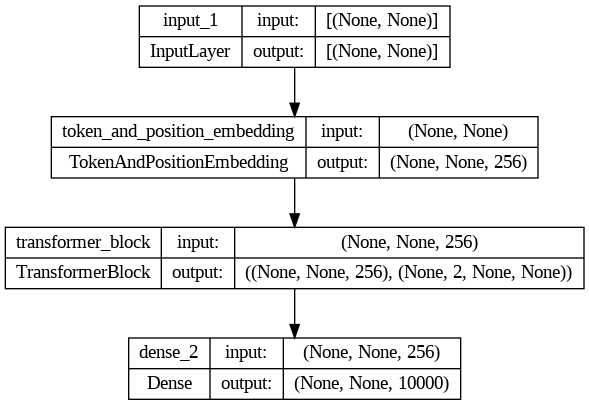

In [33]:
from tensorflow.keras.utils import plot_model
plot_model(gpt, show_shapes=True)

In [34]:
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:
            x = np.array([start_tokens])
            y, att = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1], temperature)
            info.append(
                {
                    "prompt": start_prompt,
                    "word_probs": probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_tokens.append(sample_token)
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("wine review", max_tokens=80, temperature=1.0)

In [35]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [38]:
gpt.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, tensorboard_callback, text_generator],
)

Epoch 1/5
4060/4060 [==============================] - ETA: 0s - loss: 2.2523 - dense_2_loss: 2.2523
generated text:
wine review : us : ohio : cabernet franc : made entirely from bordeaux , this cabernet ' s tart , focused cab franc shows upfront , with a penetrating structure . velvety but neither with mouthfilling and thick nor confident . concentrated , hazelnut fans of bold black fruit there ' s a bourbon - like aromas of violets and tobacco . 

4060/4060 [==============================] - 148s 35ms/step - loss: 2.2523 - dense_2_loss: 2.2523
Epoch 2/5
4060/4060 [==============================] - ETA: 0s - loss: 1.9581 - dense_2_loss: 1.9581
generated text:
wine review : us : washington : red blend : this is a copper - fruit blend of 61 % cabernet sauvignon , merlot , cabernet sauvignon and merlot . it ' s easygoing around the dinner quaff on the palate , with flavors of anise , blackberries and black pepper . 

4060/4060 [==============================] - 114s 28ms/step - loss: 1.9

In [39]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        highlighted_text = []
        for word, att_score in zip(
            i["prompt"].split(), np.mean(i["atts"], axis=0)
        ):
            highlighted_text.append(
                '<span style="background-color:rgba(135,206,250,'
                + str(att_score / max(np.mean(i["atts"], axis=0)))
                + ');">'
                + word
                + "</span>"
            )
        highlighted_text = " ".join(highlighted_text)
        display(HTML(highlighted_text))

        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [40]:
info = text_generator.generate(
    "wine review : us", max_tokens=80, temperature=1.0
)


generated text:
wine review : us : california : cabernet sauvignon : big and tannic , with ripe blackberry , cranberry and chocolate notes , this 100 % varietal wine is dry but savory and young . it will keep you high in sweet oak , but it ' s actually [UNK] a candy - wonder if [UNK] through the wine . 



In [41]:
info = text_generator.generate(
    "wine review : italy", max_tokens=80, temperature=0.5
)


generated text:
wine review : italy : tuscany : red blend : a blend of cabernet sauvignon , merlot and cabernet franc , this opens with aromas of violet , red berry and a whiff of blue flower . the palate delivers fleshy black cherry , clove and a hint of mocha alongside velvety tannins and fresh acidity . drink through 2021 . 



In [42]:
info = text_generator.generate(
    "wine review : germany", max_tokens=80, temperature=0.5
)
print_probs(info, vocab)


generated text:
wine review : germany : mosel : riesling : whiffs of smoke and petrol lend an earthy tone to fresh apple and pear flavors on this dry , medium - bodied riesling . it ' s a refreshingly tart and spry , finishing with a dry mineral tone . 



::   	100.0%
grosso:   	0.0%
-:   	0.0%
blend:   	0.0%
zealand:   	0.0%
--------



mosel:   	95.06%
rheingau:   	2.29%
rheinhessen:   	1.32%
nahe:   	1.19%
pfalz:   	0.1%
--------



::   	99.98%
-:   	0.02%
blanc:   	0.0%
valley:   	0.0%
grosso:   	0.0%
--------



riesling:   	100.0%
sparkling:   	0.0%
pinot:   	0.0%
grüner:   	0.0%
[UNK]:   	0.0%
--------



::   	100.0%
-:   	0.0%
blanc:   	0.0%
grosso:   	0.0%
':   	0.0%
--------



while:   	14.66%
a:   	14.58%
hints:   	13.12%
this:   	11.69%
whiffs:   	10.81%
--------



of:   	100.0%
suggesting:   	0.0%
blend:   	0.0%
from:   	0.0%
in:   	0.0%
--------



smoke:   	57.67%
green:   	9.44%
honey:   	4.29%
dried:   	3.27%
struck:   	2.97%
--------



and:   	93.1%
,:   	6.9%
lend:   	0.0%
lends:   	0.0%
seeps:   	0.0%
--------



crushed:   	16.43%
nuts:   	16.4%
slate:   	15.74%
struck:   	12.26%
earth:   	8.66%
--------



lend:   	78.88%
are:   	11.49%
accent:   	4.17%
add:   	1.99%
waft:   	0.9%
--------



a:   	66.65%
nuance:   	12.67%
an:   	5.97%
savoriness:   	4.75%
complexity:   	4.62%
--------



earthy:   	63.63%
exotic:   	15.9%
earthen:   	7.75%
herbaceous:   	4.1%
austere:   	3.32%
--------



tone:   	98.37%
,:   	0.63%
savoriness:   	0.3%
complexity:   	0.28%
elegance:   	0.13%
--------



to:   	100.0%
on:   	0.0%
for:   	0.0%
and:   	0.0%
of:   	0.0%
--------



this:   	91.58%
the:   	2.73%
fresh:   	2.39%
pressed:   	1.87%
a:   	0.52%
--------



apple:   	69.59%
green:   	15.13%
lemon:   	3.45%
,:   	2.51%
white:   	2.27%
--------



and:   	98.57%
flavors:   	0.52%
,:   	0.27%
aromas:   	0.17%
notes:   	0.13%
--------



pear:   	59.62%
lemon:   	13.81%
citrus:   	12.3%
lime:   	8.12%
grapefruit:   	1.44%
--------



flavors:   	69.15%
notes:   	16.47%
on:   	6.58%
aromas:   	6.44%
in:   	1.02%
--------



on:   	87.93%
in:   	11.81%
.:   	0.15%
,:   	0.04%
and:   	0.02%
--------



this:   	88.98%
the:   	11.01%
a:   	0.01%
nose:   	0.0%
an:   	0.0%
--------



dry:   	87.57%
off:   	3.57%
brisk:   	1.58%
spry:   	1.17%
light:   	1.0%
--------



,:   	78.45%
riesling:   	19.43%
-:   	0.74%
wine:   	0.25%
palate:   	0.2%
--------



medium:   	63.23%
delicately:   	9.0%
full:   	6.74%
light:   	5.08%
off:   	3.11%
--------



-:   	99.99%
bodied:   	0.01%
dry:   	0.0%
riesling:   	0.0%
body:   	0.0%
--------



bodied:   	99.87%
sweet:   	0.05%
footed:   	0.02%
weight:   	0.02%
to:   	0.01%
--------



riesling:   	93.46%
kabinett:   	5.79%
palate:   	0.23%
wine:   	0.23%
dry:   	0.13%
--------



.:   	99.99%
,:   	0.01%
that:   	0.0%
from:   	0.0%
balances:   	0.0%
--------



it:   	95.44%
the:   	1.06%
brisk:   	0.91%
a:   	0.35%
while:   	0.33%
--------



':   	99.73%
finishes:   	0.23%
is:   	0.02%
has:   	0.01%
offers:   	0.0%
--------



s:   	100.0%
ll:   	0.0%
12:   	0.0%
riesling:   	0.0%
[UNK]:   	0.0%
--------



refreshingly:   	34.82%
a:   	33.71%
dry:   	15.04%
brisk:   	4.25%
fresh:   	1.43%
--------



bit:   	69.7%
refreshingly:   	9.91%
shade:   	5.4%
brisk:   	2.28%
touch:   	1.41%
--------



quaffable:   	70.85%
spry:   	7.77%
tart:   	6.31%
crisp:   	3.2%
easy:   	2.17%
--------



,:   	68.72%
and:   	12.78%
with:   	4.51%
riesling:   	2.5%
wine:   	2.25%
--------



spry:   	57.83%
lean:   	12.19%
racy:   	3.87%
finishes:   	2.65%
brisk:   	2.52%
--------



,:   	81.43%
wine:   	10.2%
with:   	2.38%
on:   	2.23%
yet:   	1.57%
--------



finishing:   	44.31%
with:   	33.35%
but:   	15.08%
yet:   	6.51%
boasting:   	0.16%
--------



with:   	90.66%
on:   	8.7%
lean:   	0.33%
long:   	0.07%
dry:   	0.05%
--------



a:   	96.34%
hints:   	0.64%
brisk:   	0.43%
an:   	0.43%
reverberating:   	0.38%
--------



lingering:   	20.56%
hint:   	18.35%
touch:   	14.69%
reverberating:   	12.26%
shower:   	9.34%
--------



,:   	64.62%
mineral:   	28.77%
minerality:   	3.19%
lime:   	1.07%
elegance:   	0.36%
--------



tone:   	72.6%
note:   	20.23%
edge:   	2.86%
streak:   	2.4%
-:   	1.05%
--------



.:   	98.93%
and:   	0.49%
that:   	0.44%
of:   	0.12%
,:   	0.0%
--------



:   	60.18%
drink:   	39.67%
enjoy:   	0.1%
it:   	0.04%
drinks:   	0.0%
--------



In [43]:
info = text_generator.generate(
    "wine review : india", max_tokens=80, temperature=0.5
)


generated text:
wine review : india : nashik : sauvignon blanc : this wine is on the nose , with notes of green apple and lemon . it has a strong sense of coolness , with a slight green note of bell pepper on the palate . creamy flavors of green apple and freshly cut grass , green apple and green pear . 



In [46]:
info = text_generator.generate(
    "wine review : india", max_tokens=80, temperature=1
)


generated text:
wine review : india : nashik : shiraz : a perennially impresses among the ' 07 single - vineyard site , this elegant yet abundantly fruited wine boasts deep violet notes of oregano , black currant and cigar box . it comes across as well as purity . it should be cellared through 2020 . 



In [47]:
print_probs(info, vocab)

::   	99.99%
-:   	0.0%
grosso:   	0.0%
blanc:   	0.0%
blend:   	0.0%
--------



nashik:   	99.96%
[UNK]:   	0.0%
central:   	0.0%
mosel:   	0.0%
upper:   	0.0%
--------



::   	99.91%
blend:   	0.02%
blanc:   	0.01%
hills:   	0.01%
other:   	0.01%
--------



chenin:   	40.74%
sauvignon:   	19.69%
shiraz:   	11.59%
chardonnay:   	5.82%
cabernet:   	3.78%
--------



::   	99.26%
-:   	0.7%
blanc:   	0.01%
blend:   	0.01%
grosso:   	0.0%
--------



this:   	23.24%
a:   	16.71%
aromas:   	6.41%
the:   	3.03%
there:   	2.57%
--------



touch:   	9.4%
nose:   	9.32%
bouquet:   	7.87%
very:   	4.57%
soft:   	3.28%
--------



superb:   	19.53%
delicious:   	16.23%
one:   	7.47%
gorgeous:   	4.79%
beautiful:   	4.29%
--------



for:   	74.18%
in:   	5.11%
with:   	4.15%
instantly:   	2.56%
immediately:   	1.55%
--------



the:   	63.02%
its:   	13.8%
a:   	2.65%
first:   	1.66%
all:   	0.94%
--------



first:   	21.32%
nose:   	12.05%
glass:   	5.37%
most:   	4.81%
entire:   	2.08%
--------



07:   	28.1%
s:   	24.94%
05:   	16.83%
04:   	7.8%
06:   	5.07%
--------



,:   	46.04%
[UNK]:   	9.97%
-:   	6.97%
is:   	3.25%
vintage:   	2.09%
--------



-:   	86.89%
vineyard:   	6.39%
variety:   	1.14%
block:   	0.89%
varietal:   	0.75%
--------



vineyard:   	81.88%
varietal:   	5.04%
block:   	3.77%
parcel:   	1.76%
variety:   	1.43%
--------



shiraz:   	8.99%
offerings:   	8.68%
selections:   	8.3%
site:   	5.98%
,:   	5.31%
--------



,:   	48.43%
is:   	6.26%
in:   	4.54%
divided:   	2.03%
and:   	1.65%
--------



this:   	70.74%
it:   	3.18%
the:   	2.55%
a:   	1.68%
with:   	1.64%
--------



wine:   	46.32%
is:   	13.08%
full:   	3.43%
cool:   	1.75%
features:   	1.33%
--------



wine:   	47.84%
,:   	16.16%
blend:   	3.53%
white:   	2.96%
and:   	2.75%
--------



elegant:   	5.66%
still:   	4.68%
complex:   	3.32%
well:   	2.86%
refined:   	2.35%
--------



floral:   	13.55%
elegant:   	7.62%
proportioned:   	5.96%
ripe:   	3.23%
seductive:   	3.16%
--------



wine:   	86.31%
-:   	1.48%
,:   	1.38%
rosé:   	0.78%
shiraz:   	0.69%
--------



is:   	18.05%
offers:   	9.64%
features:   	8.41%
has:   	7.1%
.:   	5.63%
--------



a:   	16.55%
aromas:   	10.27%
notes:   	7.18%
deep:   	6.22%
enticing:   	3.59%
--------



aromas:   	14.37%
flavors:   	8.17%
black:   	6.07%
,:   	5.95%
ruby:   	5.72%
--------



,:   	28.9%
and:   	28.71%
aromas:   	15.79%
notes:   	12.31%
scents:   	3.21%
--------



,:   	23.47%
of:   	19.84%
and:   	15.46%
on:   	6.03%
with:   	3.82%
--------



black:   	17.24%
blueberry:   	8.2%
blackberry:   	7.83%
cherry:   	5.26%
cassis:   	5.09%
--------



,:   	76.57%
and:   	22.65%
or:   	0.2%
on:   	0.1%
.:   	0.08%
--------



thyme:   	17.53%
black:   	8.02%
bay:   	6.02%
rosemary:   	2.81%
cherry:   	2.26%
--------



cherry:   	62.66%
pepper:   	12.24%
olive:   	4.87%
currant:   	4.13%
plum:   	3.99%
--------



and:   	57.29%
,:   	38.82%
leaf:   	0.73%
.:   	0.43%
skin:   	0.29%
--------



black:   	8.46%
a:   	4.25%
blackberry:   	3.57%
cherry:   	3.47%
dark:   	2.86%
--------



box:   	80.44%
-:   	6.74%
tobacco:   	2.69%
.:   	2.67%
smoke:   	1.79%
--------



.:   	83.8%
on:   	5.04%
,:   	1.95%
spice:   	1.73%
and:   	0.43%
--------



it:   	46.84%
the:   	9.58%
there:   	5.31%
on:   	3.4%
a:   	3.38%
--------



is:   	38.15%
has:   	13.2%
':   	10.53%
feels:   	3.27%
offers:   	2.76%
--------



across:   	39.83%
through:   	21.7%
on:   	10.07%
in:   	5.54%
with:   	4.54%
--------



as:   	83.66%
the:   	3.98%
a:   	2.59%
on:   	1.55%
with:   	0.67%
--------



a:   	18.34%
well:   	4.76%
lush:   	4.46%
the:   	3.36%
soft:   	3.0%
--------



as:   	96.61%
,:   	0.98%
.:   	0.56%
on:   	0.51%
with:   	0.17%
--------



a:   	26.02%
the:   	10.22%
on:   	3.47%
an:   	2.79%
full:   	1.99%
--------



and:   	43.66%
.:   	13.13%
,:   	10.45%
of:   	10.36%
on:   	7.56%
--------



it:   	22.91%
flavors:   	12.44%
the:   	8.27%
a:   	5.63%
:   	5.37%
--------



is:   	32.7%
':   	9.6%
has:   	7.47%
finishes:   	5.2%
goes:   	3.5%
--------



be:   	63.26%
continue:   	6.44%
age:   	3.08%
develop:   	2.4%
pair:   	1.49%
--------



a:   	9.71%
cellared:   	9.35%
aged:   	7.59%
paired:   	6.04%
on:   	4.2%
--------



for:   	54.07%
until:   	11.17%
through:   	7.55%
as:   	3.83%
on:   	3.55%
--------



at:   	28.33%
2020:   	17.87%
2024:   	7.31%
2023:   	4.59%
a:   	4.25%
--------



.:   	92.23%
,:   	2.55%
to:   	2.3%
on:   	0.58%
for:   	0.44%
--------



:   	95.81%
beyond:   	0.61%
it:   	0.42%
flavors:   	0.37%
a:   	0.31%
--------

